In [11]:
import math
import numpy as np

import librosa as lr
from librosa import display

import torch 
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import IPython

## Audio to Scalogram

In [65]:
sr = 22050
clip_path = 'audio_clips/AdamSavage_2008P_13_20.wav'
#clip_path = 'audio_clips/sweep_2.wav'
#clip_path = 'audio_clips/sine.wav'

clip, sr = lr.load(clip_path, sr=sr, mono=True)
#clip = np.sin(np.arange(0, sr)*30*2*np.pi/sr)
#clip *= (1 - np.cos(np.linspace(0, 2*np.pi, sr))) * 0.5
IPython.display.Audio(clip, rate=sr)

In [66]:
hop_length = 128
fmin=30
bins_per_octave=32
n_bins = 250

clip_cqt = lr.cqt(clip, hop_length=hop_length, sr=sr, fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins, filter_scale=1.)
clip_cqt_abs = np.abs(clip_cqt)
clip_cqt_ang = np.angle(clip_cqt)

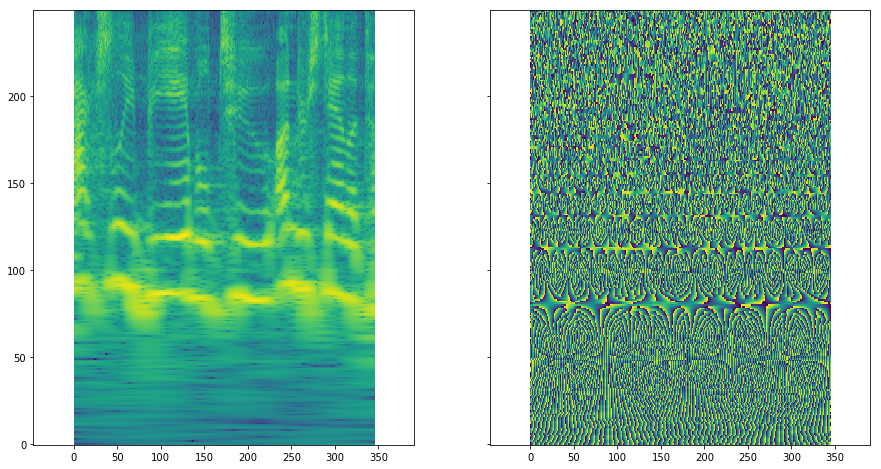

In [107]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
ax1.imshow(np.log(clip_cqt_abs**2), origin='lower', aspect=2.)
ax2.imshow(clip_cqt_ang, origin='lower', aspect=2.)
plt.show()

## Scalogram to Audio

In [123]:
reconstructed_clip = lr.icqt(clip_cqt, hop_length=hop_length, fmin=fmin, bins_per_octave=bins_per_octave, filter_scale=1.)
IPython.display.Audio(reconstructed_clip, rate=sr)

/Users/vincentherrmann/anaconda3/lib/python3.5/site-packages/librosa/core/constantq.py:615: UserWarning: librosa.icqt is unstable, and subject to change in future versions. Please use with caution.
  warnings.warn('librosa.icqt is unstable, and subject to change in future versions. '


## Phase Difference

In [197]:
def unwrap(x):
    x[np.greater(x, np.pi)] = x[np.greater(x, np.pi)] - 2*np.pi
    x[np.less(x, -np.pi)] = x[np.less(x, -np.pi)] + 2*np.pi
    return x

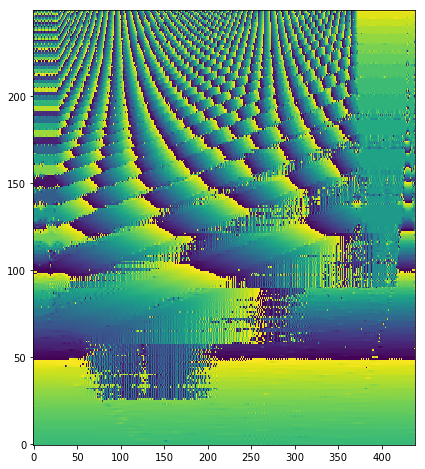

In [188]:
clip_phase_diff = np.diff(np.unwrap(clip_cqt_ang), axis=1)

fig = plt.figure(figsize=(8, 8))
plt.imshow(clip_phase_diff, origin='lower', aspect=2.)
plt.show()

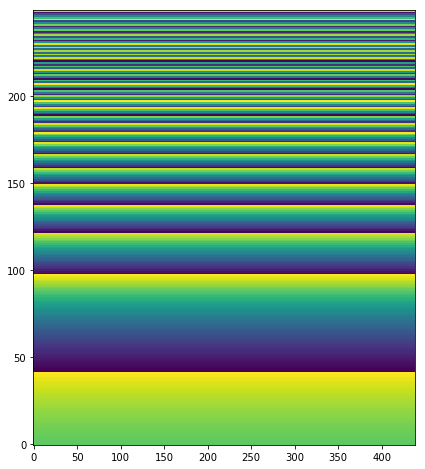

In [195]:
cqt_frequencies = lr.time_frequency.cqt_frequencies(fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins)
default_phase_diff = ((cqt_frequencies / (0.5 * sr / hop_length)) + np.pi) % 2*np.pi - np.pi

fig = plt.figure(figsize=(8, 8))
plt.imshow(np.repeat(default_phase_diff.reshape(-1, 1), clip_phase_diff.shape[1], axis=1), origin='lower', aspect=2.)
plt.show()

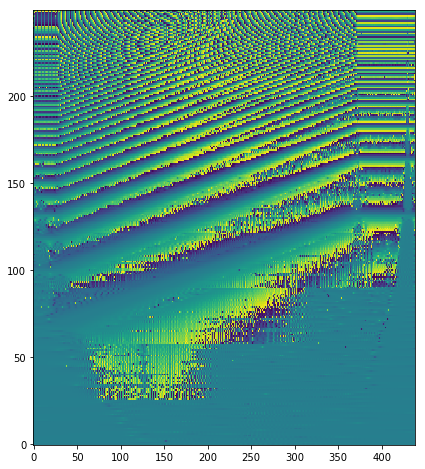

In [198]:
clip_phase_diff_deviation = unwrap(clip_phase_diff - default_phase_diff.reshape(-1, 1))

fig = plt.figure(figsize=(8, 8))
plt.imshow(clip_phase_diff_deviation, origin='lower', aspect=2.)
plt.show()

### Simplified Phase Difference
(weighted PDD)

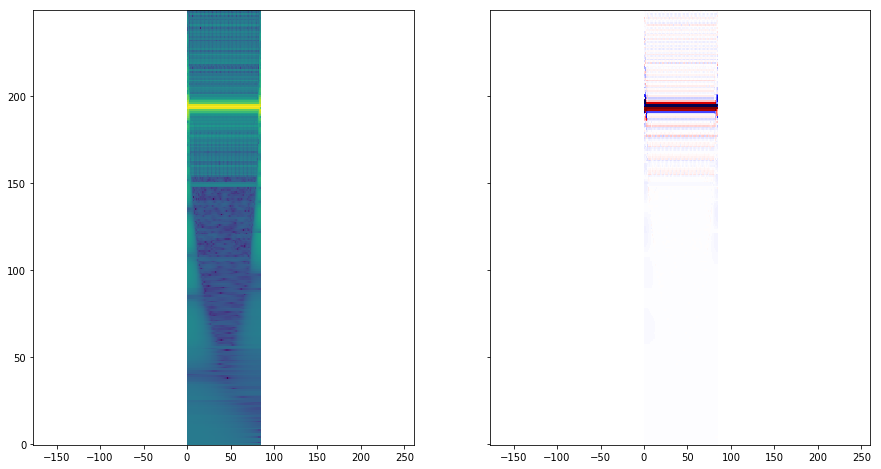

In [128]:
weighted_pdd = clip_phase_diff_deviation * clip_cqt_abs[:, :-1]**0.5

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
ax1.imshow(np.log(clip_cqt_abs**2), origin='lower', aspect=2.)
ax2.imshow(weighted_pdd, origin='lower', aspect=2., cmap='seismic', vmin=-1., vmax=1.)
plt.show()


/Users/vincentherrmann/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vincentherrmann/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


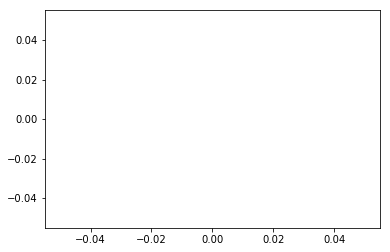

In [129]:
plt.plot(np.mean(weighted_pdd[:, 110:111], axis=1))
plt.plot(np.mean(weighted_pdd[:, 135:136], axis=1))
plt.plot(np.mean(weighted_pdd[:, 160:161], axis=1))
plt.show()

Reconstruction of phase from weighted PDD:

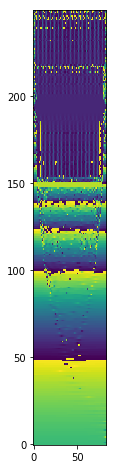

In [130]:
step_1 = weighted_pdd / clip_cqt_abs[:, :-1]**0.5
step_2 = unwrap(step_1 + default_phase_diff.reshape(-1, 1))

fig = plt.figure(figsize=(8, 8))
plt.imshow(step_2, origin='lower', aspect=2.)
plt.show()

## PyTorch CQT

In [18]:
def complex_multiply(a, b, complex_dim_a=None, complex_dim_b=None):
    #if a.shape != b.shape:
    #    print('a and b must have the same shape')
    #    print('shape a:', a.shape, 'shape b:', b.shape) 
    
    if complex_dim_a is None:
        complex_dim_a = len(a.shape) - 1
        
    if complex_dim_b is None:
        complex_dim_b = len(b.shape) - 1

    real_a = torch.index_select(a, complex_dim_a, torch.LongTensor([0])).squeeze(complex_dim_a)
    imag_a = torch.index_select(a, complex_dim_a, torch.LongTensor([1])).squeeze(complex_dim_a)
    real_b = torch.index_select(b, complex_dim_b, torch.LongTensor([0])).squeeze(complex_dim_b)
    imag_b = torch.index_select(b, complex_dim_b, torch.LongTensor([1])).squeeze(complex_dim_b)
    
    product_real = real_a * real_b - imag_a * imag_b
    product_imag = real_a * imag_b + imag_a * real_b
    
    stack_dim = max(complex_dim_a, complex_dim_b)
    return torch.stack([product_real, product_imag], dim=stack_dim)
    
def abs(z, complex_dim=None):
    if complex_dim is None:
        complex_dim = len(z.shape) - 1
    real = torch.index_select(z, complex_dim, torch.LongTensor([0])).squeeze(dim=complex_dim)
    imag = torch.index_select(z, complex_dim, torch.LongTensor([1])).squeeze(dim=complex_dim)
    return torch.sqrt(real**2 + imag**2)

def angle(z, complex_dim=None):
    if complex_dim is None:
        complex_dim = len(z.shape) - 1
    real = torch.index_select(z, complex_dim, torch.LongTensor([0])).squeeze(dim=complex_dim)
    imag = torch.index_select(z, complex_dim, torch.LongTensor([1])).squeeze(dim=complex_dim)
    return torch.atan2(imag, real)

def to_complex(real, imag, complex_dim=None):
    if complex_dim is None:
        complex_dim = len(real.shape)
    return torch.stack([real, imag], dim=complex_dim)

def ifft_shift(x):
    n = math.ceil(x.shape[1] / 2)
    m = math.floor(x.shape[1] / 2)
    shifted_x = torch.zeros_like(x)
    shifted_x[:, :m, :] = x[:, n:, :]
    shifted_x[:, m:, :] = x[:, :n, :]
    return shifted_x

def torch_cqt(x, filters, norm_factors=1., hop_length=128):
    x_fft = torch.rfft(x, signal_ndim=1, onesided=True, normalized=False)
    product = complex_multiply(x_fft.unsqueeze(1), filters[:, :x_fft.shape[1], :].unsqueeze(0))
    cqt = torch.ifft(product, signal_ndim=1, normalized=False)[:, ::hop_length]
    cqt = ifft_shift(cqt)
    
    cqt *= norm_factors * 0.5
    return cqt

class CQT(nn.Module):
    def __init__(self, sr=16000, fmin=30, n_bins=256, bins_per_octave=32, filter_scale=1., hop_length=128):
        super().__init__()
        
        self.hop_length = hop_length
        
        # load filters
        cqt_filters, cqt_filter_lenghts = lr.filters.constant_q(sr, 
                                                                fmin=fmin, 
                                                                n_bins=n_bins, 
                                                                bins_per_octave=bins_per_octave, 
                                                                filter_scale=filter_scale)
        self.cqt_filter_lengths = cqt_filter_lenghts
        
        # one convolution operation per octave
        self.conv_kernel_sizes = [] # the kernel sizes of the octaves
        self.conv_index_ranges = [] # the indices belonging to each convolution operation
        current_kernel_size = None
        last_change_index = 0
        for i, l in enumerate(cqt_filter_lenghts):
            kernel_size = 2**math.ceil(np.log2(l))
            if current_kernel_size is not None and kernel_size >= current_kernel_size:
                # continue if this is in the same octave
                continue
            self.conv_kernel_sizes.append(kernel_size)
            current_kernel_size = kernel_size
            if i != 0:
                self.conv_index_ranges.append(range(last_change_index, i))
            last_change_index = i
        self.conv_index_ranges.append(range(last_change_index, len(self.cqt_filter_lengths)))
        
        filter_length = cqt_filters.shape[-1]
        self.conv_modules = []
        for i, size in enumerate(self.conv_kernel_sizes):
            this_range = self.conv_index_ranges[i]
            offset = (filter_length - size) // 2
            if offset > 0:
                this_filter = cqt_filters[this_range, offset:-offset]
            else:
                this_filter = cqt_filters[this_range, :]
            this_filter = torch.cat([torch.from_numpy(np.real(this_filter)),
                                     torch.from_numpy(np.imag(this_filter))], dim=0).type(torch.FloatTensor)
            #print(this_filter.shape)
            this_conv = nn.Conv1d(in_channels=1, out_channels=this_filter.shape[0], kernel_size=size, bias=False, stride=hop_length, padding=size//2)
            this_conv.weight = torch.nn.Parameter(this_filter.unsqueeze(1))
            self.conv_modules.append(this_conv)
        
    def forward(self, x):
        real = []
        imag = []
        for conv in self.conv_modules:
            conv_result = conv(x)
            r, i = torch.chunk(conv_result, 2, dim=1)
            real.append(r)
            imag.append(i)
        real = torch.cat(real, dim=1)
        imag = torch.cat(imag, dim=1)
        return torch.stack([real, imag], dim=3)

In [19]:
cqt_module = CQT(sr=sr, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)

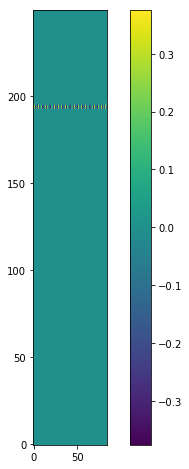

In [20]:
torch_clip = torch.from_numpy(clip).type(torch.FloatTensor)
torch_cqt = cqt_module(torch_clip.view(1, 1, -1)*1).squeeze()
torch_cqt_abs = abs(torch_cqt, complex_dim=2).squeeze()
torch_cqt_angle = angle(torch_cqt, complex_dim=2).squeeze()

fig = plt.figure(figsize=(8, 8))
plt.imshow(torch_cqt[:, :, 0].detach(), aspect=2., origin='lower')
plt.colorbar()
plt.show()

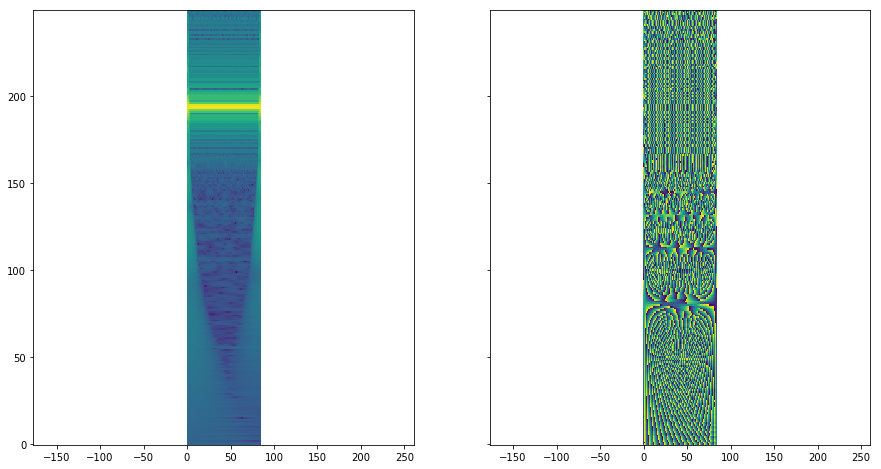

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
ax1.imshow(torch.log(torch_cqt_abs**2).squeeze().detach(), origin='lower', aspect=2.)
ax2.imshow(torch_cqt_angle.squeeze().detach(), origin='lower', aspect=2.)
plt.show()

In [22]:
def unwrap(x):
    x[torch.gt(x, np.pi)] -= 2*np.pi
    x[torch.lt(x, -np.pi)] += 2*np.pi
    return x

def phase_diff(x):
    out_shape = list(x.shape)
    l = out_shape[-1]
    out_shape[-1] -= 1
    #print("phase diff shape:", out_shape)
    return (x.view(-1, l)[:, :-1] - x.view(-1, l)[:, 1:]).view(out_shape)

class PhaseDiffDeviation(nn.Module):
    def __init__(self, sr=16000, fmin=30, n_bins=256, bins_per_octave=32, hop_length=128):
        super().__init__()
        
        cqt_frequencies = lr.time_frequency.cqt_frequencies(fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins)
        default_phase_diff = ((cqt_frequencies / (0.5 * sr / hop_length)) + np.pi) % 2*np.pi - np.pi
        self.dpd = torch.from_numpy(default_phase_diff).type(torch.FloatTensor).unsqueeze(1)
        #print("dpd shape:", self.dpd.shape)
        
    def forward(self, x):
        #print("x shape:", x.shape)
        x_abs = abs(x)
        x_angle = angle(x)
        p = unwrap(phase_diff(x_angle))
        p = unwrap(p - self.dpd)
        p = p * x_abs[:, :, :-1]**0.5
        return torch.stack([x_abs[:, :, :-1], p], dim=3) 

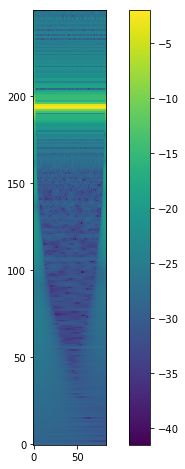

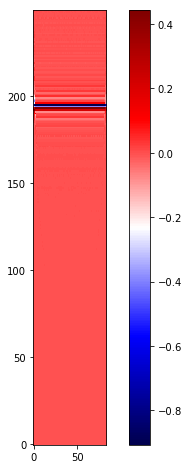

In [23]:
pdd_module = PhaseDiffDeviation(sr=sr, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, hop_length=hop_length)
res = cqt_module(torch_clip.view(1, 1, -1)*1)
res = pdd_module(res)

fig = plt.figure(figsize=(8, 8))
plt.imshow(torch.log(res[0, :, :, 0].detach()**2), origin='lower', aspect=2.)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8, 8))
plt.imshow(res[0, :, :, 1].detach(), origin='lower', aspect=2., cmap='seismic')
plt.colorbar()
plt.show()

## Scalogram Optimization

In [24]:
signal = (torch.rand_like(torch_clip) - 0.5) * 0.01
signal.requires_grad = True
scal_target = res.detach()[0, :, :, 0]**0.5
pdd_target = res.detach()[0, :, :, 1]

optimizer = torch.optim.Adam([signal], lr=0.001)

IPython.display.Audio(signal.detach(), rate=sr)

In [25]:
for i in range(1000):
    s_res = cqt_module(signal.view(1, 1, -1)*1)
    
    s_res = pdd_module(s_res)
    s_scal = s_res[0, :, :, 0]**0.5
    s_pdd = s_res[0, :, :, 1]
    
    scal_loss = torch.mean((s_scal - scal_target)**2)
    pdd_loss = torch.mean((s_pdd - pdd_target)**2)
    loss = 1000. * scal_loss + 1000. * pdd_loss
    
    print("loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

loss: 7.998205184936523
loss: 7.788732528686523
loss: 7.627595901489258
loss: 7.505685806274414
loss: 7.4167799949646
loss: 7.336401462554932
loss: 7.27503776550293
loss: 7.18503475189209
loss: 7.143553733825684
loss: 7.110753059387207
loss: 7.05510950088501
loss: 7.000387668609619
loss: 6.975334167480469
loss: 6.924567222595215
loss: 6.884848117828369
loss: 6.8363189697265625
loss: 6.795691967010498
loss: 6.779792785644531
loss: 6.731645584106445
loss: 6.682503700256348
loss: 6.668125152587891
loss: 6.631373882293701
loss: 6.612322807312012
loss: 6.5822858810424805
loss: 6.541502952575684
loss: 6.5446248054504395
loss: 6.514884948730469
loss: 6.495245933532715
loss: 6.467022895812988
loss: 6.440162181854248
loss: 6.437038898468018
loss: 6.4137349128723145
loss: 6.3896660804748535
loss: 6.368671417236328
loss: 6.380764961242676
loss: 6.358214378356934
loss: 6.335498332977295
loss: 6.315019130706787
loss: 6.297074317932129
loss: 6.2765960693359375
loss: 6.255435943603516
loss: 6.2366900

loss: 4.443892002105713
loss: 4.474258899688721
loss: 4.4673662185668945
loss: 4.46592903137207
loss: 4.461785316467285
loss: 4.458946704864502
loss: 4.455645561218262
loss: 4.451861381530762
loss: 4.448993682861328
loss: 4.445158004760742
loss: 4.441287517547607
loss: 4.438290596008301
loss: 4.434206962585449
loss: 4.430865287780762
loss: 4.427048206329346
loss: 4.423133373260498
loss: 4.420271873474121
loss: 4.4177727699279785
loss: 4.415371894836426
loss: 4.412304878234863
loss: 4.409302711486816
loss: 4.406088829040527
loss: 4.408273220062256
loss: 4.407641887664795
loss: 4.401186943054199
loss: 4.398502349853516
loss: 4.395150184631348
loss: 4.393187522888184
loss: 4.389649391174316
loss: 4.386842727661133
loss: 4.384377956390381
loss: 4.381260871887207
loss: 4.378547668457031
loss: 4.376418113708496
loss: 4.374903202056885
loss: 4.372195243835449
loss: 4.369835376739502
loss: 4.3670430183410645
loss: 4.365543365478516
loss: 4.36229133605957
loss: 4.359611511230469
loss: 4.3570337

loss: 3.8529882431030273
loss: 3.850982904434204
loss: 3.851409673690796
loss: 3.8496055603027344
loss: 3.848419427871704
loss: 3.8463010787963867
loss: 3.846571683883667
loss: 3.8439245223999023
loss: 3.8431363105773926
loss: 3.842050552368164
loss: 3.8377561569213867
loss: 3.836731195449829
loss: 3.8356308937072754
loss: 3.8340420722961426
loss: 3.8316047191619873
loss: 3.8299238681793213
loss: 3.827953338623047
loss: 3.826563835144043
loss: 3.825199604034424
loss: 3.824148178100586
loss: 3.8233394622802734
loss: 3.8223319053649902
loss: 3.8206400871276855
loss: 3.8192524909973145
loss: 3.817256212234497
loss: 3.815434455871582
loss: 3.8126344680786133
loss: 3.8104348182678223
loss: 3.809285879135132
loss: 3.80732798576355
loss: 3.805245876312256
loss: 3.8043980598449707
loss: 3.8015401363372803
loss: 3.7995738983154297
loss: 3.797578811645508
loss: 3.795062780380249
loss: 3.793642044067383
loss: 3.7913148403167725
loss: 3.7902793884277344
loss: 3.788346290588379
loss: 3.785942077636

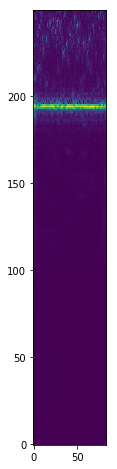

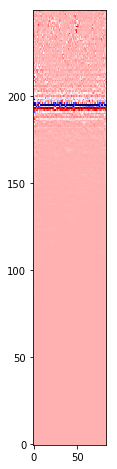

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(s_scal.detach(), origin='lower', aspect=2.)
plt.show()

fig = plt.figure(figsize=(8, 8))
plt.imshow(s_pdd.detach(), origin='lower', aspect=2., cmap='seismic')
plt.show()

IPython.display.Audio(signal.detach(), rate=sr)

In [43]:
s_res = cqt_module(signal.view(1, 1, -1)*1)

s_res = pdd_module(s_res)
s_scal = s_res[0, :, :, 0]**0.5
s_pdd = s_res[0, :, :, 1]

scal_loss = torch.mean((s_scal - scal_target)**2)
pdd_loss = torch.mean((s_pdd - pdd_target)**2)
loss = 0. * scal_loss + 1000. * pdd_loss

print("loss:", loss.item())

optimizer.zero_grad()
loss.backward()
optimizer.step()

loss: 1.3338927030563354


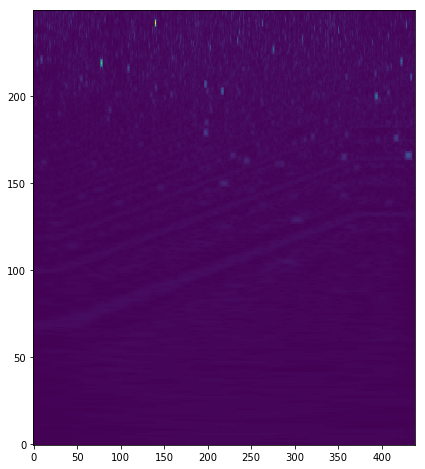

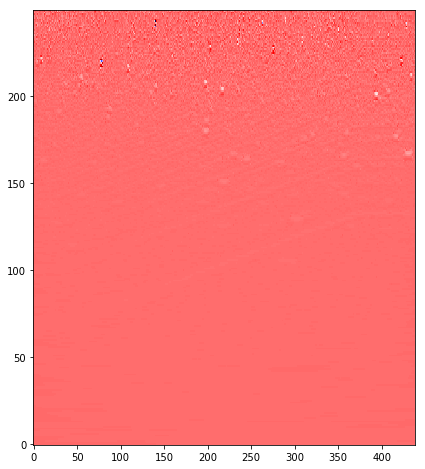

In [15]:
grad = signal.grad
grad_cqt = cqt_module(grad.view(1, 1, -1)*1)
grad_res = pdd_module(grad_cqt)
grad_scal = grad_res[0, :, :, 0]**0.5
grad_pdd = grad_res[0, :, :, 1]

fig = plt.figure(figsize=(8, 8))
plt.imshow(grad_scal.detach(), origin='lower', aspect=2.)
plt.show()

fig = plt.figure(figsize=(8, 8))
plt.imshow(grad_pdd.detach(), origin='lower', aspect=2., cmap='seismic')
plt.show()

## Reassignment

In [151]:
def hann_t(n):
    '''
    time weighed hann window
    '''
    x = np.linspace(-1, 1, n, endpoint=False)
    return x * (np.cos(np.pi * x)*0.5 + 0.5)

def hann_dt(n):
    '''
    time derivative of the hann window
    '''
    x = np.linspace(0, 2, n, endpoint=False)
    return 0.5 * np.sin(np.pi * x)

def cqt_reassignment(x, 
                     sr=22050, 
                     hop_length=512, 
                     fmin=lr.note_to_hz('C1'), 
                     n_bins=84, 
                     bins_per_octave=12, 
                     tuning=0.0, 
                     filter_scale=1,
                     reassignment_hop_length=None,
                     reassignment_bins_per_octave=None):
    
    # frequencies and filter lengths of the constant q filters
    frequencies = lr.core.cqt_frequencies(n_bins, fmin, bins_per_octave, tuning)
    filter_lengths = lr.filters.constant_q_lengths(sr, fmin, n_bins, bins_per_octave, tuning, 'hann', filter_scale).reshape(-1, 1)
    
    scaling = (1/filter_lengths**0.5)
    scaling = scaling.reshape(-1,1)
    
    # ordinary constant q transform
    cqt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                      bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                      window='hann', scale=False, norm=np.inf) * scaling
    
    # cqt with time weighed window for time reassignment
    cqt_t = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                        bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                        window=hann_t, scale=False, norm=np.inf) * scaling
    
    # cqt with time derivative window for frequency reassignment
    cqt_dt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                         bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                         window=hann_dt, scale=False, norm=np.inf) * scaling 
    
    time_steps = cqt.shape[1]
    
    if reassignment_hop_length is None:
        reassignment_hop_length = hop_length
        
    if reassignment_bins_per_octave is None:
        reassignment_bins_per_octave = bins_per_octave
        
    reassignment_bins = math.ceil(n_bins * (reassignment_bins_per_octave / bins_per_octave))
    reassignment_time_steps = math.ceil(time_steps * (hop_length / reassignment_hop_length))
    
    cqt_abs = np.abs(cqt)
    cqt_sq = cqt_abs**2
    
    frequency_shifts =  np.imag(cqt_dt * np.conj(cqt)) / (filter_lengths * cqt_sq)
    frequency_shifts = np.nan_to_num(frequency_shifts) * sr * 0.5
    
    time_shifts = np.real(filter_lengths * cqt_t * np.conj(cqt) / cqt_sq)
    time_shifts = np.nan_to_num(time_shifts) / reassignment_hop_length * 0.131 * 0.0
    
    reassigned_cqt = np.zeros([reassignment_bins, reassignment_time_steps])
    oct_min = lr.hz_to_octs(fmin)
    
    bin_factor = reassignment_bins / n_bins
    time_factor = reassignment_time_steps / time_steps
    
    # fill the reassignmed scalogram
    for b in range(n_bins):
        for t in range(time_steps):
            f_bin = math.floor(b * bin_factor)
            t_bin = math.floor(t * time_factor)
            
            if cqt_abs[b, t] > 0.1: # only reassign if there is enough energy
                freq = frequencies[b] + frequency_shifts[b, t]
                freq = max(freq, fmin)
                f_bin = math.floor((lr.hz_to_octs(freq) - oct_min) * reassignment_bins_per_octave + 0.5)
                f_bin = min(max(f_bin, 0), reassignment_bins-1)
                
                t_bin = math.floor(t * time_factor + time_shifts[b, t] + 0.5)
                t_bin = min(max(t_bin, 0), reassignment_time_steps-1)

            reassigned_cqt[f_bin, t_bin] += cqt_abs[b, t] 
            
    return reassigned_cqt


def wavelet_sst(x, 
                sr=22050, 
                hop_length=512, 
                fmin=lr.note_to_hz('C1'), 
                n_bins=84, 
                bins_per_octave=12, 
                tuning=0.0, 
                filter_scale=1,
                reassignment_hop_length=None,
                reassignment_bins_per_octave=None):
    # frequencies and filter lengths of the constant q filters
    frequencies = lr.core.cqt_frequencies(n_bins, fmin, bins_per_octave, tuning)
    filter_lengths = lr.filters.constant_q_lengths(sr, fmin, n_bins, bins_per_octave, tuning, 'hann', filter_scale).reshape(-1, 1)
    
    scaling = (1/filter_lengths**0.5)
    scaling = scaling.reshape(-1,1)
    
    # ordinary constant q transform
    cqt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                      bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                      window='hann', scale=False, norm=np.inf) * scaling
    
    # cqt with time derivative window for frequency reassignment
    cqt_dt = lr.core.cqt(x, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, 
                         bins_per_octave=bins_per_octave, tuning=tuning, filter_scale=filter_scale,
                         window=hann_dt, scale=False, norm=np.inf) * scaling 
    
    time_steps = cqt.shape[1]
    
    if reassignment_hop_length is None:
        reassignment_hop_length = hop_length
        
    if reassignment_bins_per_octave is None:
        reassignment_bins_per_octave = bins_per_octave
        
    reassignment_bins = math.ceil(n_bins * (reassignment_bins_per_octave / bins_per_octave))
    reassignment_time_steps = math.ceil(time_steps * (hop_length / reassignment_hop_length))
    
    cqt_abs = np.abs(cqt)
    cqt_sq = cqt_abs**2
    
    frequency_shifts =  np.imag(cqt_dt * np.conj(cqt)) / (filter_lengths * cqt_sq)
    frequency_shifts = np.nan_to_num(frequency_shifts) * sr * 0.5
    
    reassigned_cqt = np.zeros([reassignment_bins, reassignment_time_steps], dtype=np.complex128)
    oct_min = lr.hz_to_octs(fmin)
    
    bin_factor = reassignment_bins / n_bins
    time_factor = reassignment_time_steps / time_steps
    
    # fill the reassignmed scalogram
    for b in range(n_bins):
        for t in range(time_steps):
            f_bin = math.floor(b * bin_factor)
            t_bin = math.floor(t * time_factor)
            
            if cqt_abs[b, t] > 0.1: # only reassign if there is enough energy
                freq = frequencies[b] + frequency_shifts[b, t]
                freq = max(freq, fmin)
                f_bin = math.floor((lr.hz_to_octs(freq) - oct_min) * reassignment_bins_per_octave + 0.5)
                f_bin = min(max(f_bin, 0), reassignment_bins-1)
            
            time_position = reassignment_hop_length / sr
            freq_position = fmin + fmin * 2**(f_bin/reassignment_bins_per_octave)
            reassigned_cqt[f_bin, t_bin] += cqt[b, t] * np.exp(1j * time_position * freq_position)
            
    return reassigned_cqt

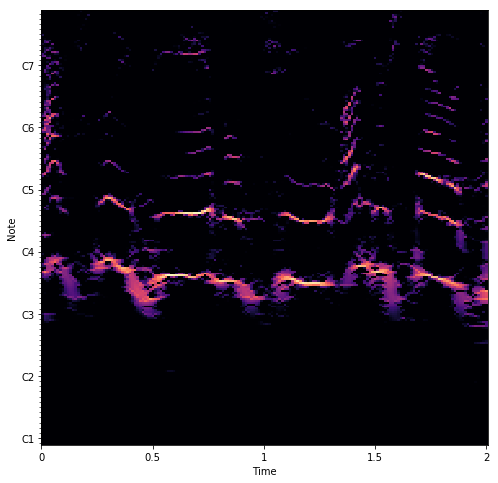

In [152]:
signal = clip
bins_per_octave=32
octaves = 7
fmin = 30.
hop_length=128
filter_scale = 0.5

reassignment_hop_length=256
reassignment_bins_per_octave=32

reassigned_cqt = cqt_reassignment(signal, 
                                  sr=sr, 
                                  n_bins=octaves*bins_per_octave, 
                                  bins_per_octave=bins_per_octave,
                                  filter_scale=filter_scale, 
                                  hop_length=hop_length,
                                  fmin=fmin,
                                  reassignment_hop_length=reassignment_hop_length,
                                  reassignment_bins_per_octave=reassignment_bins_per_octave)   

fig, ax = plt.subplots(1, 1, figsize=[8, 8])
lr.display.specshow(lr.amplitude_to_db(reassigned_cqt**2, ref=np.max),
                    y_axis='cqt_note', x_axis='time', hop_length=reassignment_hop_length, sr=sr, bins_per_octave=reassignment_bins_per_octave,
                    fmin=fmin, cmap='magma', )
plt.show()
IPython.display.Audio(signal, rate=sr)

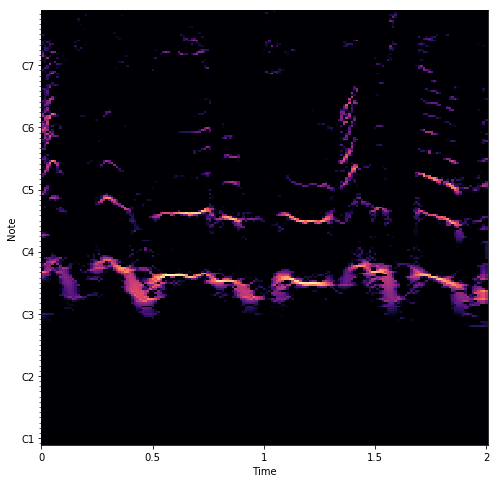

In [153]:
sst = wavelet_sst(signal, 
                  sr=sr, 
                  n_bins=octaves*bins_per_octave, 
                  bins_per_octave=bins_per_octave,
                  filter_scale=filter_scale, 
                  hop_length=hop_length,
                  fmin=fmin,
                  reassignment_hop_length=reassignment_hop_length,
                  reassignment_bins_per_octave=reassignment_bins_per_octave)   

fig, ax = plt.subplots(1, 1, figsize=[8, 8])
lr.display.specshow(lr.amplitude_to_db(np.abs(sst)**2, ref=np.max),
                    y_axis='cqt_note', x_axis='time', hop_length=reassignment_hop_length, sr=sr, bins_per_octave=reassignment_bins_per_octave,
                    fmin=fmin, cmap='magma')
plt.show()
IPython.display.Audio(signal, rate=sr)

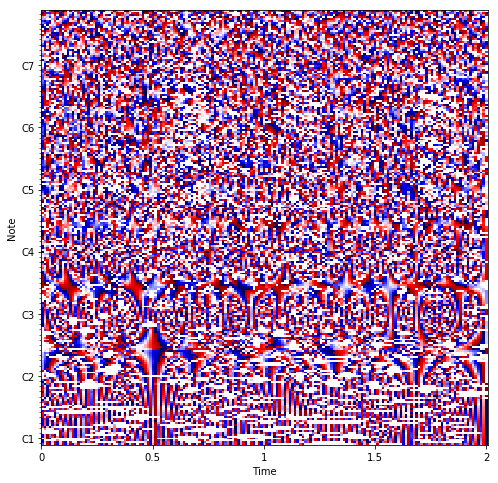

In [155]:
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
lr.display.specshow(np.angle(sst),
                    y_axis='cqt_note', x_axis='time', hop_length=reassignment_hop_length, sr=sr, bins_per_octave=reassignment_bins_per_octave,
                    fmin=fmin, cmap='seismic')
plt.show()

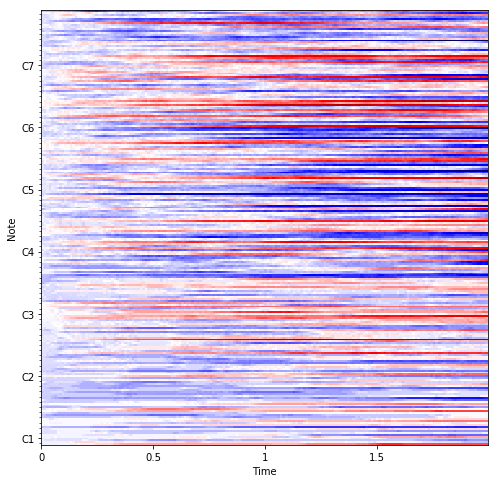

In [162]:
angle_diff = np.unwrap(np.diff(np.angle(sst), axis=1))

fig, ax = plt.subplots(1, 1, figsize=[8, 8])
lr.display.specshow(angle_diff,
                    y_axis='cqt_note', x_axis='time', hop_length=reassignment_hop_length, sr=sr, bins_per_octave=reassignment_bins_per_octave,
                    fmin=fmin, cmap='seismic')
plt.show()

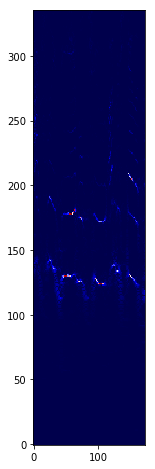

(336, 173)


In [70]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(reassigned_cqt, origin='lower', aspect=2., cmap='seismic')
plt.show()

print(reassigned_cqt.shape)

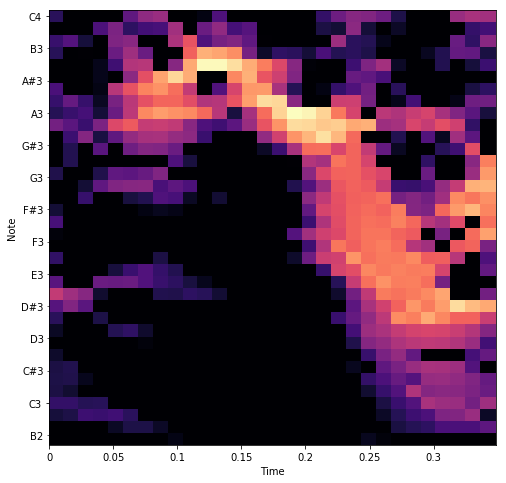

In [178]:
r_cqt_snippet = reassigned_cqt[64:100, 15:45]
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
lr.display.specshow(lr.amplitude_to_db(r_cqt_snippet**2, ref=np.max),
                    y_axis='cqt_note', x_axis='time', hop_length=reassignment_hop_length, sr=sr, bins_per_octave=reassignment_bins_per_octave,
                    fmin=fmin*4, cmap='magma', )
plt.show()

In [193]:
freqs = [[120 * 2**(i/32) for i in range(r_cqt_snippet.shape[0])]]
freqs = np.asarray(freqs)
print(freqs)
lin_spaces = np.ones([r_cqt_snippet.shape[0], r_cqt_snippet.shape[1]*reassignment_hop_length])
lin_spaces *= freqs.T / sr
lin_spaces = np.cumsum(lin_spaces, axis=1)
sines = np.sin(lin_spaces)

[[ 120.          122.62765784  125.31285389  128.05684808  130.86092792
   133.72640911  136.65463617  139.64698305  142.7048538   145.8296832
   149.02293745  152.28611486  155.62074656  159.02839718  162.51066563
   166.06918584  169.70562748  173.42169684  177.21913751  181.09973131
   185.06529905  189.11770141  193.25883983  197.49065738  201.81513966
   206.23431577  210.75025924  215.365089    220.08097037  224.90011609
   229.82478737  234.8572949   240.          245.25531568  250.62570778
   256.11369616]]


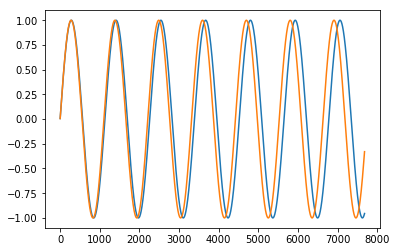

In [195]:
plt.plot(sines[1, :])
plt.plot(sines[2, :])
plt.show()

## Crazy Climbers

/Users/vincentherrmann/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: overflow encountered in exp


550


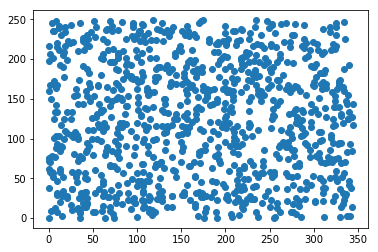

210


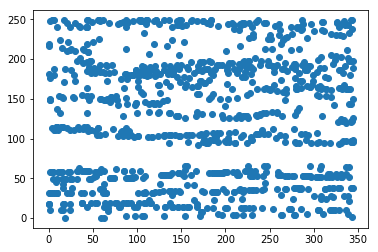

237


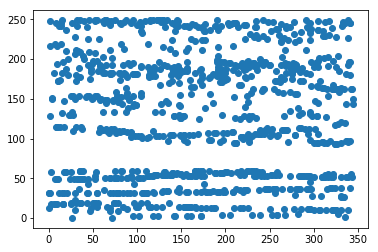

234


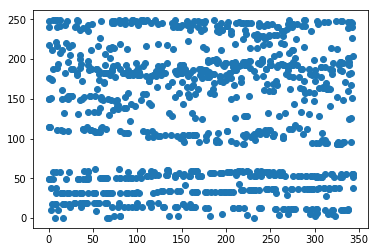

244


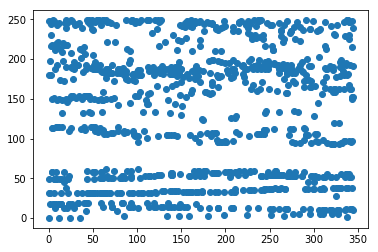

230


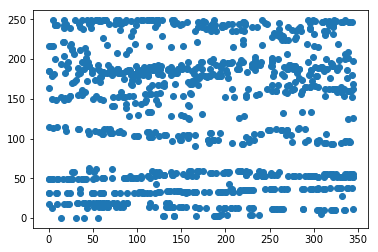

In [112]:
def crazy_climbers(g, n=500, t=1000):
    height = g.shape[0]
    width = g.shape[1]
    climbers = np.stack([np.random.randint(0, height, n), np.random.randint(0, width, n)], axis=1)
    #print(climbers)
    
    for t in range(t):
        # horizontal movement
        random_movements = np.random.randint(0, 2, n) * 2 - 1
        climbers[:, 1] += random_movements
        climbers[:, 1] = np.clip(climbers[:, 1], 0, width-1)
        
        # vertical movement
        random_movements = np.random.randint(0, 2, n) * 2 - 1
        possible_new_positions = np.copy(climbers)
        possible_new_positions[:, 0] += random_movements
        possible_new_positions[:, 0] = np.clip(possible_new_positions[:, 0], 0, height-1)
        values = g[climbers[:, 0], climbers[:, 1]]
        delta = g[possible_new_positions[:, 0], possible_new_positions[:, 1]] - values
        #print(delta)
        move_probability = np.exp(100*delta/values)
        #
        make_move = np.random.rand(n) < move_probability
        
        #print(make_move)
        climbers[:, 0] += random_movements * make_move
        climbers[:, 0] = np.clip(climbers[:, 0], 0, height-1)
        #print(climbers)
        
        if t % 10000 == 0:
            #plt.close()
            print(np.sum(make_move))
            #print(move_probability)
            plt.scatter(climbers[:, 1], climbers[:, 0])
            plt.show()
    return climbers

test_grid = np.zeros([100, 100]) + 0.2
test_grid[25:50, :] += 1.
test_grid[60:80, :] += 1.
#test_grid = lr.amplitude_to_db(reassigned_cqt**2, ref=np.max)
test_grid = np.log(clip_cqt_abs**2)
climbers = crazy_climbers(test_grid, n=1000, t=50001)

In [48]:
plt.scatter(climbers[:, 0], climbers[:, 1], ylim=[0, 100])
plt.show()

AttributeError: Unknown property ylim

In [73]:
[1, 1] * [True, False]

TypeError: can't multiply sequence by non-int of type 'list'